[I 2025-08-06 20:22:56,045] A new study created in memory with name: no-name-b3ec210c-ad97-4a66-91f8-5099098a4adc
[I 2025-08-06 20:23:10,788] Trial 0 finished with value: 0.6227685577449609 and parameters: {'hidden1': 77, 'hidden2': 63, 'dropout_rate': 0.4921184290202465, 'activation': 'relu', 'optimizer': 'Adam', 'lr': 0.003955124000908202, 'epochs': 165}. Best is trial 0 with value: 0.6227685577449609.
[I 2025-08-06 20:23:17,166] Trial 1 finished with value: 0.6189542880089972 and parameters: {'hidden1': 44, 'hidden2': 49, 'dropout_rate': 0.1916909022152733, 'activation': 'relu', 'optimizer': 'Adam', 'lr': 0.0017588426584170213, 'epochs': 80}. Best is trial 1 with value: 0.6189542880089972.
[I 2025-08-06 20:23:23,341] Trial 2 finished with value: 0.6245100953650237 and parameters: {'hidden1': 101, 'hidden2': 64, 'dropout_rate': 0.17360330564635768, 'activation': 'relu', 'optimizer': 'Adam', 'lr': 0.00395245821986397, 'epochs': 69}. Best is trial 1 with value: 0.6189542880089972.
[I 2

最优超参数: {'hidden1': 44, 'hidden2': 49, 'dropout_rate': 0.1916909022152733, 'activation': 'relu', 'optimizer': 'Adam', 'lr': 0.0017588426584170213, 'epochs': 80}

测试集准确率: 0.5700

分类报告:
              precision    recall  f1-score   support

           0       0.28      0.20      0.24        98
           1       0.66      0.75      0.70       202

    accuracy                           0.57       300
   macro avg       0.47      0.48      0.47       300
weighted avg       0.54      0.57      0.55       300



E:\Software second place\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\Software second place\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\Software second place\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\Software second place\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\Software second place\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu San

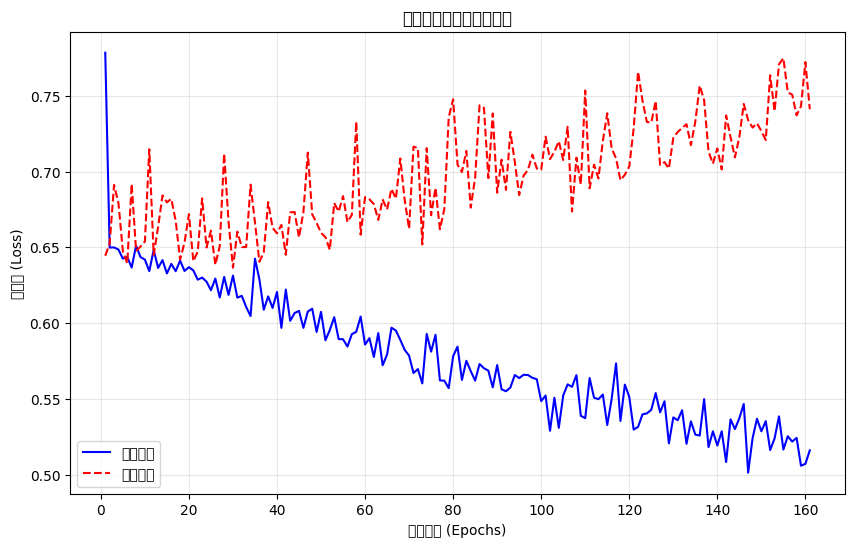

In [22]:

import numpy as np
import torch
import optuna
import torch.nn as nn
import pandas as pd
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1. 数据预处理（Data Preprocessing）
# ------------------------------------------------------
# 加载数据（替换为你的数据集路径）
df = pd.read_csv('diabetes_prediction_dataset_2000_samples_2025.csv')

# 定义特征和目标变量（根据实际列名调整）
features = ['bmi_2024', 'lifestyleScore_2024', 'fastingGlucose_2024',
            'postprandialGlucose_2024', 'randomGlucose_2024', 'pulsePresure_2024']
numerical_features = features  # 假设所有特征为数值型
target = 'Diabetes_2025'  # 目标变量：0=未患病，1=患病

# 划分特征和目标
X = df[features]
y = df[target].values

# 数据划分（训练集70%，验证集15%，测试集15%）
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val
)  # 0.1765 ≈ 0.15/0.85

# 预处理管道（缺失值填充+标准化+独热编码）
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), features),  # 数值型用中位数填充
    ])

# 拟合预处理并转换数据
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# 标准化数值特征（仅对数值部分处理）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_val_scaled = scaler.transform(X_val_processed)
X_test_scaled = scaler.transform(X_test_processed)

# 转换为PyTorch张量
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 创建DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
batch_size = 32  # 后续Optuna会调优，这里先设默认值
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ------------------------------------------------------
# 2. 模型构建（含Dropout层）
# ------------------------------------------------------
class DiabetesClassifier(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, dropout_rate, activation):
        super().__init__()
        # 激活函数选择
        self.activation_name = activation  # 保存激活函数名称用于匹配
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        else:
            raise ValueError(f"不支持的激活函数: {activation}")

        # 带Dropout的神经网络结构
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden1, hidden2),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden2, 2)  # 二分类输出层
        )

    def forward(self, x):
        return self.model(x)

# ------------------------------------------------------
# 3. Optuna超参数调优
# ------------------------------------------------------
def objective(trial):
    input_dim = X_train_scaled.shape[1]  # 输入特征维度

    # 待调优超参数
    params = {
        'hidden1': trial.suggest_int('hidden1', 32, 128),
        'hidden2': trial.suggest_int('hidden2', 16, 64),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'leaky_relu']),
        'optimizer': trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop']),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'epochs': trial.suggest_int('epochs', 50, 200)
    }

    # 初始化模型
    model = DiabetesClassifier(
        input_dim=input_dim,
        hidden1=params['hidden1'],
        hidden2=params['hidden2'],
        dropout_rate=params['dropout_rate'],
        activation=params['activation']
    )

    # 损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['lr'])

    # 训练与验证
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(params['epochs']):
        # 训练
        model.train()
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x_batch.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # 验证
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * x_batch.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # 早停机制（可选）
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'state_dict': model.state_dict(),
                'params': params  # params是当前试验的超参数
            }, 'best_model.pth')

        # 剪枝（提前终止无效试验）
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_val_loss

# 运行调优
study = optuna.create_study(direction='minimize')  # 最小化验证损失
study.optimize(objective, n_trials=30)  # 尝试30组超参数
print(f"最优超参数: {study.best_params}")

# ------------------------------------------------------
# 4. 用最优参数训练最终模型并评估
# ------------------------------------------------------
# 获取最优试验的模型路径和参数
checkpoint = torch.load('best_model.pth')
loaded_params = checkpoint['params']
# 用完全相同的参数初始化模型
input_dim = X_train_scaled.shape[1]


# 用保存的超参数初始化模型（确保结构100%匹配）
final_model = DiabetesClassifier(
    input_dim=input_dim,
    hidden1=loaded_params['hidden1'],
    hidden2=loaded_params['hidden2'],
    dropout_rate=loaded_params['dropout_rate'],
    activation=loaded_params['activation']
)
# 加载权重
final_model.load_state_dict(checkpoint['state_dict'])

# 定义损失函数和优化器（用最优超参数）
criterion = nn.CrossEntropyLoss()
optimizer = getattr(optim, best_params['optimizer'])(final_model.parameters(), lr=best_params['lr'])

#记录重新训练过程的损失（用于可视化）
train_losses = []  # 训练集损失
val_losses = []    # 验证集损失

for epoch in range(best_params['epochs']):
    # 训练
    final_model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = final_model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # 验证
    final_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            outputs = final_model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * x_batch.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

# 测试集评估
final_model.eval()
with torch.no_grad():
    test_outputs = final_model(X_test_tensor)
    _, test_preds = torch.max(test_outputs, 1)
#计算评估指标
test_accuracy = accuracy_score(y_test, test_preds.numpy())
print(f"\n测试集准确率: {test_accuracy:.4f}")
print("\n分类报告:")
print(classification_report(y_test, test_preds.numpy()))

# ------------------------------------------------------
# 5. 绘制训练/验证损失曲线
# ------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(range(1, best_params['epochs']+1), train_losses, label='训练损失', color='blue')
plt.plot(range(1, best_params['epochs']+1), val_losses, label='验证损失', color='red', linestyle='--')
plt.xlabel('训练轮数 (Epochs)')
plt.ylabel('损失值 (Loss)')
plt.title('训练损失与验证损失趋势')
plt.legend()
plt.grid(alpha=0.3)
plt.show()